In [9]:
import os, shutil

# 훈련, 검증, 테스트 데이터 directory 저장
train_dir = './datasets/train'
validation_dir = './datasets/validation'
test_dir = './datasets/test'

# train directory
train_pikachu_dir = './datasets/train/피카츄'
train_spongebob_dir = './datasets/train/스폰지밥'

# validation directory
validation_pikachu_dir = './datasets/validation/피카츄'
validation_spongebob_dir = './datasets/validation/스폰지밥'

# test directory
test_pikachu_dir = './datasets/test/피카츄'
test_spongebob_dir = './datasets/test/스폰지밥'
    
print('훈련용 피카츄 이미지 전체 개수:', len(os.listdir(train_pikachu_dir)))
print('훈련용 스폰지밥 이미지 전체 개수:', len(os.listdir(train_spongebob_dir)))
print('검증용 피카츄 이미지 전체 개수:', len(os.listdir(validation_pikachu_dir)))
print('검증용 스폰지밥 이미지 전체 개수:', len(os.listdir(validation_spongebob_dir)))
print('테스트용 피카츄 이미지 전체 개수:', len(os.listdir(test_pikachu_dir)))
print('테스트용 스폰지밥 이미지 전체 개수:', len(os.listdir(test_spongebob_dir)))

훈련용 피카츄 이미지 전체 개수: 20
훈련용 스폰지밥 이미지 전체 개수: 20
검증용 피카츄 이미지 전체 개수: 5
검증용 스폰지밥 이미지 전체 개수: 5
테스트용 피카츄 이미지 전체 개수: 5
테스트용 스폰지밥 이미지 전체 개수: 5


In [10]:
import tensorflow.keras

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 40)
validation_features, validation_labels = extract_features(validation_dir, 10)
test_features, test_labels = extract_features(test_dir, 10)

Using TensorFlow backend.


Found 40 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [5]:
# fully connected layer에 넣기 위해 flatten

train_features = np.reshape(train_features, (40, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (10, 4 * 4 * 512))
test_features = np.reshape(test_features, (10, 4 * 4 * 512))

In [6]:
# dense layer 학습

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=2,
                    validation_data=(validation_features, validation_labels))

Train on 40 samples, validate on 10 samples
Epoch 1/30
40/40 [==============================] - 7s 169ms/sample - loss: 0.8760 - acc: 0.4750 - val_loss: 0.7216 - val_acc: 0.6000
Epoch 2/30
40/40 [==============================] - 0s 2ms/sample - loss: 0.5811 - acc: 0.6500 - val_loss: 0.5370 - val_acc: 0.8000
Epoch 3/30
40/40 [==============================] - 0s 2ms/sample - loss: 0.3967 - acc: 0.9000 - val_loss: 0.4215 - val_acc: 0.9000
Epoch 4/30
40/40 [==============================] - 0s 1ms/sample - loss: 0.2802 - acc: 0.9000 - val_loss: 0.3370 - val_acc: 0.9000
Epoch 5/30
40/40 [==============================] - 0s 1ms/sample - loss: 0.1726 - acc: 1.0000 - val_loss: 0.2753 - val_acc: 0.9000
Epoch 6/30
40/40 [==============================] - 0s 1ms/sample - loss: 0.2012 - acc: 0.9750 - val_loss: 0.2197 - val_acc: 0.9000
Epoch 7/30
40/40 [==============================] - 0s 1ms/sample - loss: 0.1035 - acc: 1.0000 - val_loss: 0.1812 - val_acc: 0.9000
Epoch 8/30
40/40 [============

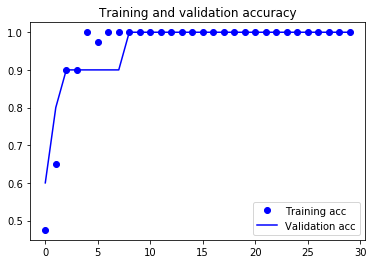

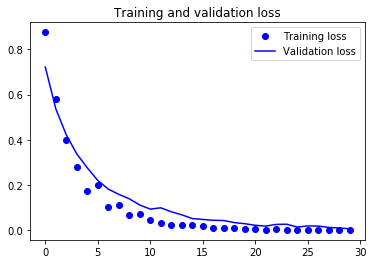

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
# VGG16의 conv layer 추가

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers작

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


conv_base.trainable = False # conv layer 동결하여 기존 학습된 weight사용

# Data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식하지 않는다.
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요하다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=2,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 40 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/30
2/2 - 38s - loss: 0.6551 - acc: 0.6750 - val_loss: 0.5119 - val_acc: 0.8000
Epoch 2/30
2/2 - 38s - loss: 0.5255 - acc: 0.8750 - val_loss: 0.4216 - val_acc: 1.0000
Epoch 3/30
2/2 - 41s - loss: 0.4161 - acc: 0.9750 - val_loss: 0.3727 - val_acc: 1.0000
Epoch 4/30
2/2 - 41s - loss: 0.3846 - acc: 0.9750 - val_loss: 0.3257 - val_acc: 1.0000
Epoch 5/30
2/2 - 40s - loss: 0.3525 - acc: 1.0000 - val_loss: 0.2914 - val_acc: 1.0000
Epoch 6/30
2/2 - 40s - loss: 0.3403 - acc: 1.0000 - val_loss: 0.2593 - val_acc: 1.0000
Epoch 7/30
2/2 - 40s - loss: 0.2789 - acc: 1.0000 - val_loss: 0.2350 - val_acc: 1.0000
Epoch 8/30
2/2 - 41s - loss: 0.2630 - acc: 1.0000 - val_loss: 0.2188 - val_acc: 1.0000
Epoch 9/30
2/2 - 41s - loss: 0.2290 - acc: 1.0000 - val_loss: 0.2005 - val_acc: 1.0000
Epoch 10/30
2/2 - 40s - loss: 0.2147 - acc: 1.0000 - val_loss: 0.1830 - val_acc: 1.0000
Epoch 11/30
2/2 - 40s - loss: 0.2001 - acc: 1.000

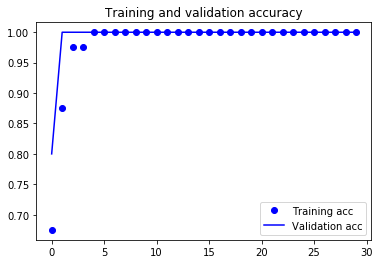

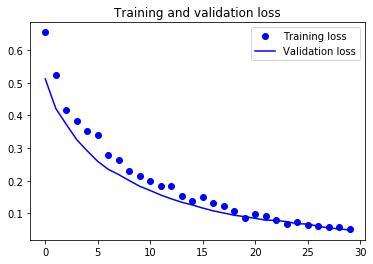

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()